In [1]:
%matplotlib inline
import numpy as np
import torch
from d2l import torch as d2l
from torch import nn

In [2]:
timer = d2l.Timer()
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)
for i in range(256):
    for j in range(256):
        A[i][j] = torch.dot(B[i, :], C[:, j])
timer.stop()

1.1784703731536865

In [3]:
timer.start()
for i in range(256):
    A[:, i] = torch.mv(B, C[:, i])
print(f'{A.shape}')
timer.stop()

torch.Size([256, 256])


0.012992620468139648

In [4]:
timer.start()
A = torch.mm(B, C)
timer.stop()

print(f'{timer.times}')

[1.1784703731536865, 0.012992620468139648, 0.0009989738464355469]


In [6]:
timer.start()
for i in range(0, 256, 64):
    A[:, i:i + 64] = torch.mm(B, C[:, i:i + 64])
timer.stop()

0.003988504409790039

In [7]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

def get_data_ch11(batch_size=10, n=1500):
    """ 返回data_iter、features_dim """
    data = np.genfromtxt(d2l.download('airfoil'), dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))  # axis=0 按行
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]), batch_size=batch_size, is_train=True)
    return data_iter, data.shape[1] - 1

In [8]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

In [11]:
def train_ch11(trainer_fn, states, hyperparams, data_iter, feature_dim, num_epochs=2):
    w = torch.normal(mean=0., std=.01, size=(feature_dim, 1), requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss

    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, num_epochs], ylim=[.22, .35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter), (d2l.evaluate_loss(net, data_iter, loss), ))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

loss: 0.251, 0.032 sec/epoch


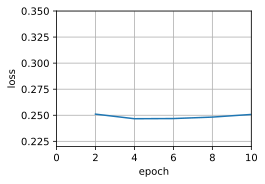

In [13]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(sgd, None, {'lr':lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

loss: 0.243, 0.065 sec/epoch


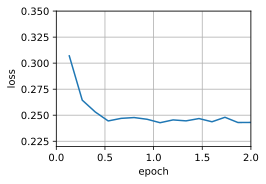

In [14]:
sgd_res = train_sgd(.005, 1)

loss: 0.244, 0.004 sec/epoch


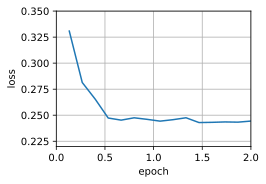

In [15]:
minil_res = train_sgd(.4, 100)

loss: 0.245, 0.009 sec/epoch


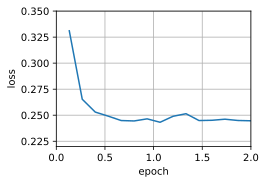

In [16]:
mini2_res = train_sgd(.05, 10)

In [21]:
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    net = nn.Sequential(nn.Linear(5, 1))
    
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, num_epochs], ylim=[.22, .35])
    n, timer = 0, d2l.Timer()

    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n / X.shape[0] / len(data_iter), (d2l.evaluate_loss(net, data_iter, loss) / 2))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

loss: 0.242, 0.010 sec/epoch


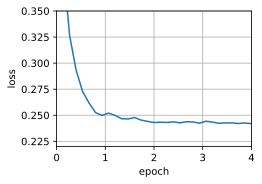

In [22]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr':.01}, data_iter)